### Let's use a benchmark BEM problem to test if the current functions are working correctly.

In [1]:
%matplotlib widget

In [2]:
from acousticBEM.AcousticProperties import *
from acousticBEM.BoundaryData import *
from acousticBEM.ExampleBoundaries import *
from acousticBEM.Geometry import *
from acousticBEM.HelmholtzIntegrals2D import *
from acousticBEM.HelmholtzSolver import *
from acousticBEM.HelmholtzSolver2D import *

In [3]:
import numpy as np
from numpy import log, sin, cos, arctan2, pi, mean, dot
from numpy.linalg import norm, solve
from scipy.special import roots_legendre, hankel1
from scipy.integrate import quad
import matplotlib.pyplot as plt
from misc.add_funs_mod import *
import meshio
import gmsh
import sys

### Define the circle's geometry (.geo file)

In [4]:
def create_circle_geo(fname, radius, ngrid_pts):

    geom_file = open(fname + ".geo", "w", encoding="utf-8")
    
    geom_file.write(" /* \n " +
                    ".geo file for simple circle boundary, \n"+
                    "Introduccion al Metodo de Frontera Universidad EAFIT 2025-1 \n"+
                    "by: Daniel Ospina Pajoy, Sebastián Duque Lotero & Mateo Tabares. \n */ "+
                    "\n \n \n")
    
    geom_file.write("// Points \n") 
    geom_file.write(f"Point(1) = {{ 0.0 , 0.0 , 0.0, 0.5 }}; \n")
    geom_file.write(f"Point(2) = {{ {-radius}*Cos(Pi/4), {-radius}*Cos(Pi/4), 0.0, 0.5 }}; \n")
    geom_file.write(f"Point(3) = {{ {radius}*Cos(Pi/4), {-radius}*Cos(Pi/4), 0.0, 0.5 }}; \n")
    geom_file.write(f"Point(4) = {{ {radius}*Cos(Pi/4), {radius}*Cos(Pi/4), 0.0, 0.5 }}; \n")
    geom_file.write(f"Point(5) = {{ {-radius}*Cos(Pi/4), {radius}*Cos(Pi/4), 0.0, 0.5 }}; \n")
    geom_file.write("\n \n") 
    
    geom_file.write("// Lines \n") 
    geom_file.write("Circle(1) = { 2, 1, 3 } ; \n")
    geom_file.write("Circle(2) = { 3, 1, 4 } ; \n")
    geom_file.write("Circle(3) = { 4, 1, 5 } ; \n")
    geom_file.write("Circle(4) = { 5, 1, 2 } ; \n")
    geom_file.write("\n \n") 
    
    geom_file.write("// Surfaces \n"+
                    "Curve Loop(1) = { 1,2,3,4 }; \n"+
                   "Plane Surface(1) = {1}; \n") 
    geom_file.write("\n \n") 
    
    geom_file.write("// Physical groups \n"+
                    "Physical Curve(1) = { 1,2,3,4 }; \n"+
                   "Physical Surface(2) = {1}; \n") 
    geom_file.write("\n \n") 
    
    
    ndiv = ngrid_pts
    geom_file.write("// Mesh parameters \n"+
                   f"ndiv = {ndiv}; \n"+
                   "Transfinite Curve { 1,2,3, 4 } = ndiv Using Progression 1; \n"+
                   "Transfinite Surface {1}; \n") 
        
    geom_file.close()

In [5]:
f_name = "simple_circle_bound"
create_circle_geo(fname = f_name, radius = 7, ngrid_pts = 20)
gmsh.initialize()
gmsh.open(f_name+".geo")
gmsh.model.mesh.generate(1)  # 1D mesh

gmsh.write(f_name+".msh")
gmsh.finalize()


In [6]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = read_geo_gmsh(f_name+".msh", [0,1,2,3], None)
elems = np.flip(elems[:, ::-1], axis=0) # For interior problems
x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T

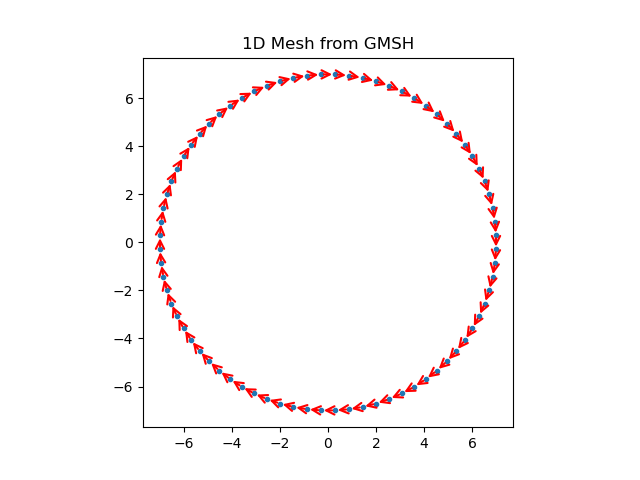

In [7]:
# Plot the surface
plt.close('all')

fig, ax = plt.subplots()
plot = ax.plot(coords[:,0], coords[:,1],".")

for elem in elems:
    i, j = elem  # indices of connected points
    x0, y0 = coords[i]
    x1, y1 = coords[j]
    dx, dy = x1 - x0, y1 - y0
    
    ax.annotate("",
                xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(arrowstyle="->", color='red', lw=1.5),
                size=15)

    
ax.set_aspect('equal', 'box')
plt.title(r"1D Mesh from GMSH")
plt.show()

---

### Parametric Definition of the Scatterer and the Circle (for plotting)

In [8]:
alpha = 0.65
beta = 1.5
multiply = 2

n_points = 30
t = np.linspace(0, 2*np.pi, n_points)

x_scatterer = ( np.cos(t) + alpha * np.cos(2*t) ) * multiply 
x_scatterer = x_scatterer - np.mean(x_scatterer)
y_scatterer = beta * np.sin(t) * multiply

x_circle = np.cos(t) * 7
y_circle = np.sin(t) * 7

---

---

### Original field (Analytic)

In [9]:
# Screen width and height
upper_grid_size = 15
lower_grid_size = -upper_grid_size
ngrid_pts = 200

grid_vec = np.linspace(lower_grid_size, upper_grid_size, num=ngrid_pts)
X,Y = np.meshgrid(grid_vec, grid_vec)

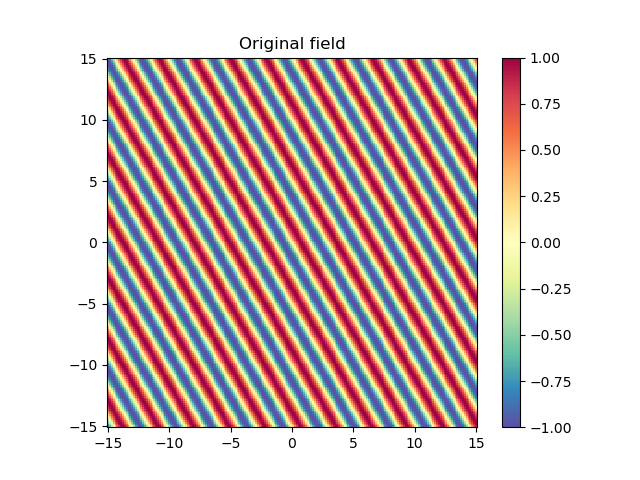

In [10]:
# Define the incident wave-field function
ui_fun = lambda k, x, y, theta : np.sin( k * (x * np.cos(theta) + y * np.sin(theta) ) )

# Define the wave with parameters. U_i
k = 2.5
angle = np.pi/6
u_i = ui_fun(k, X, Y, angle)

# Plot the surface
fig, ax = plt.subplots()
plot = ax.pcolormesh(X, Y, u_i, edgecolor="none",cmap="Spectral_r")
ax.axis('equal')
ax.set_aspect('equal', 'box')

cbar = fig.colorbar(plot,ax=ax)
plt.title(r"Original field")
plt.show()

---

### BEM alternative

In [11]:
u_i_boundary = ui_fun(k, x_m, y_m, angle)
u_d = -u_i_boundary

In [12]:
u_boundary = np.zeros(x_m.shape[0])
u_boundary[id_dir] = u_d

---


In [13]:
solver = HelmholtzSolver2D( aVertex = coords, aElement = elems, c = 344.0, density = 1.205)

In [14]:
# Dirichlet conditions at every element, thus alpha is flled with 1 and beta with 0
boundaryCondition = BoundaryCondition(solver.aElement.shape[0])
boundaryCondition.alpha.fill(1.0) # Dirichlet
boundaryCondition.beta.fill(0.0) # Neumann
boundaryCondition.f[:] = u_boundary

boundaryIncidence = BoundaryIncidence(solver.aElement.shape[0])
boundaryIncidence.phi.fill(0.0)
boundaryIncidence.v.fill(0.0)

In [15]:
X_flat = X.flatten()
Y_flat = Y.flatten()
eval_points = np.column_stack((X_flat, Y_flat))

interiorIncidentPhi = np.zeros(eval_points.shape[0], dtype=np.complex64)

In [16]:
boundarySolution = solver.solveInteriorBoundary(k, boundaryCondition, boundaryIncidence)
interiorPhi = solver.solveInterior(boundarySolution, interiorIncidentPhi, eval_points)

In [17]:
boundarySolution.aPhi.real

array([-0.97656703, -0.99917716, -0.98389012, -0.98013562, -0.99498731,
       -0.99304247, -0.89893901, -0.61861867, -0.10457607,  0.53580856,
        0.97328663,  0.80199718, -0.03338576, -0.88338101, -0.8019101 ,
        0.26512203,  0.9991554 ,  0.2922734 , -0.87412858, -0.63039142,
        0.6742574 ,  0.82102966, -0.46336532, -0.93844241,  0.20892684,
        0.9989717 ,  0.15168214, -0.92423314, -0.63054299,  0.51271564,
        0.99279815,  0.36543554, -0.5804016 , -0.99883264, -0.72573984,
       -0.10664939,  0.472242  ,  0.83041751,  0.97656703,  0.99917716,
        0.98389012,  0.98013562,  0.99498731,  0.99304247,  0.89893901,
        0.61861867,  0.10457607, -0.53580856, -0.97328663, -0.80199718,
        0.03338576,  0.88338101,  0.8019101 , -0.26512203, -0.9991554 ,
       -0.2922734 ,  0.87412858,  0.63039142, -0.6742574 , -0.82102966,
        0.46336532,  0.93844241, -0.20892684, -0.9989717 , -0.15168214,
        0.92423314,  0.63054299, -0.51271564, -0.99279815, -0.36

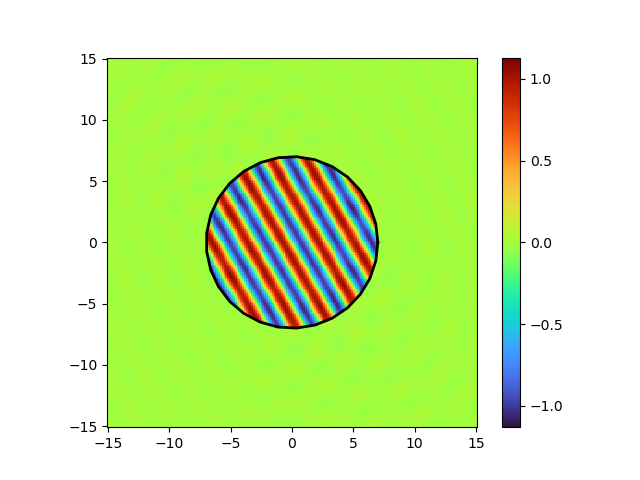

In [24]:
bem_field = (interiorPhi.reshape((Y.shape))).real

fig2, ax2 = plt.subplots()
plot = ax2.pcolormesh(X, Y, bem_field, edgecolor="none", cmap="turbo")

ax2.plot(x_circle, y_circle, color='black', lw=2)

ax2.axis('equal')
ax2.set_aspect('equal', 'box')

cbar = fig2.colorbar(plot,ax=ax2)
plt.show()

---

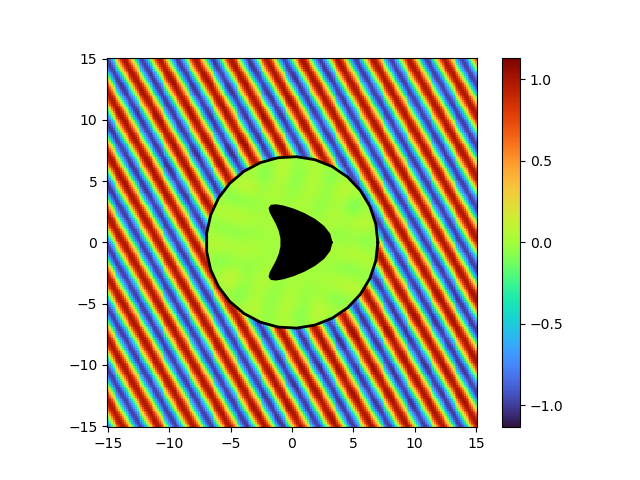

In [26]:
fig3, ax3 = plt.subplots()
plot = ax3.pcolormesh(X, Y, (ui_fun(k,X,Y, angle) + bem_field) , edgecolor="none",cmap="turbo")
ax3.axis('equal')
ax3.set_aspect('equal', 'box')

ax3.plot(x_circle, y_circle, color='black', lw=2)
ax3.plot(x_scatterer, y_scatterer, color='black', lw=2)

plt.fill(x_scatterer, y_scatterer,"k")

cbar = fig3.colorbar(plot,ax=ax3)
plt.show()